In this notebook, we go through clustering methods over correlation distance matrix,
$d_{i, j} = \sqrt{\frac{1}{2} (1 - \rho_{i, j})}$. Especially, we try out k-means clustering. In k-means algorithm, you need to pick up the number of clusters, K, in advance. To tune this parameter, we introduce clustering quality metric, silhouette coefficient,
$$S_i = \frac{b_i - a_i}{max\{a_i, b_i\}}, \forall i = 1, ..., N$$
, where $b_i$ and $a_i$ are average distance from different cluster points and the same cluster points.

If clustering is completely at random, these two distance would be closer, so $S_i$ would be around zero on the average. The better quality, the close to 1 the metric becomes. To aggregate value on each point, we use the following
$$q = \frac{Mean[S_i]}{Std[S_i]}$$

Our clustering algorithm is briefly the following:
1. Find the best kmeans over 1-K cluster numbers
2. Iterate with different initialization
3. Try further 1 and 2 on set of clusters: $\{q_k | q_k < E[q],  k=1, ..., K\}$

Step 1 and 2 are implemented as `cluster_kmeans_base`. Step 1-3 are implemented as `cluster_kmeans_top`. 

The detail of implementations will be found at finance_ml/clustering.py.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Experiments on Random block Correlation Matrices

We generate correlation matrix, where strong correlation only within the same block.

In [4]:
from finance_ml.experiments import get_random_block_corr

x = get_random_block_corr(100, 10, is_shuffle=False, sigma=1)
print(x.shape)
x.head()

ModuleNotFoundError: No module named 'sklearn.neighbors.kde'

In [4]:
import seaborn as sns

sns.heatmap(x);

NameError: name 'x' is not defined

Before shuffling, you see several blocks in the correlation matrix.

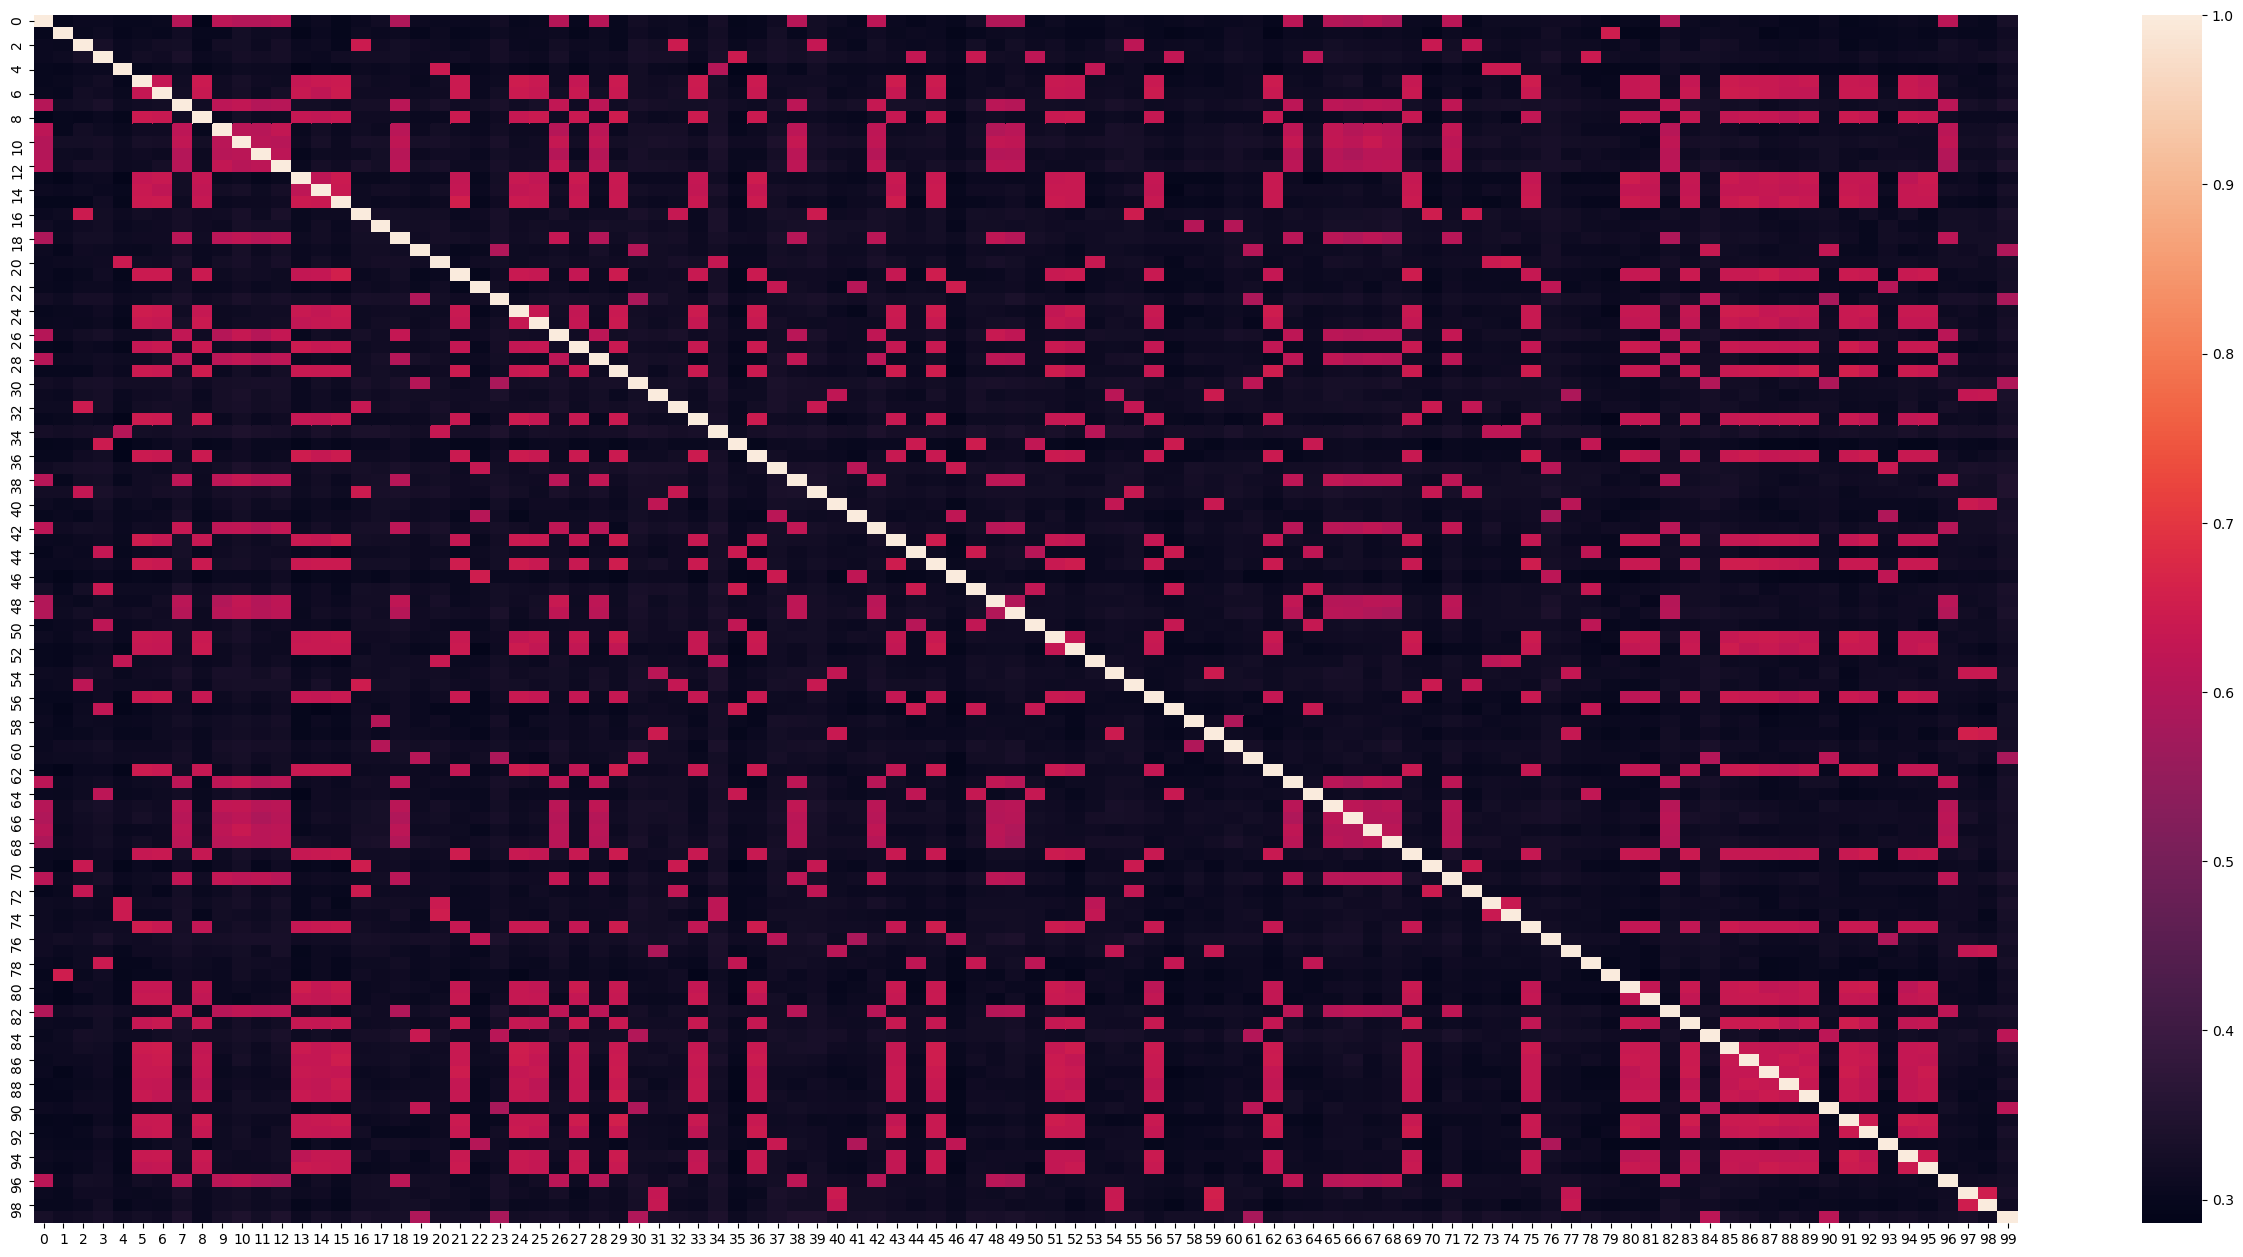

In [4]:
from finance_ml.experiments import get_random_block_corr

x = get_random_block_corr(100, 10, is_shuffle=True, sigma=1)
sns.heatmap(x);

Let's re-find clusters from this matrix.

The number of clusters: 10
{0: [1, 79], 1: [31, 40, 54, 59, 77, 97, 98], 2: [5, 6, 8, 13, 14, 15, 21, 24, 25, 27, 29, 33, 36, 43, 45, 51, 52, 56, 62, 69, 75, 80, 81, 83, 85, 86, 87, 88, 89, 91, 92, 94, 95], 3: [0, 7, 9, 10, 11, 12, 18, 26, 28, 38, 42, 48, 49, 63, 65, 66, 67, 68, 71, 82, 96], 4: [19, 23, 30, 61, 84, 90, 99], 5: [3, 35, 44, 47, 50, 57, 64, 78], 6: [2, 16, 32, 39, 55, 70, 72], 7: [22, 37, 41, 46, 76, 93], 8: [17, 58, 60], 9: [4, 20, 34, 53, 73, 74]}


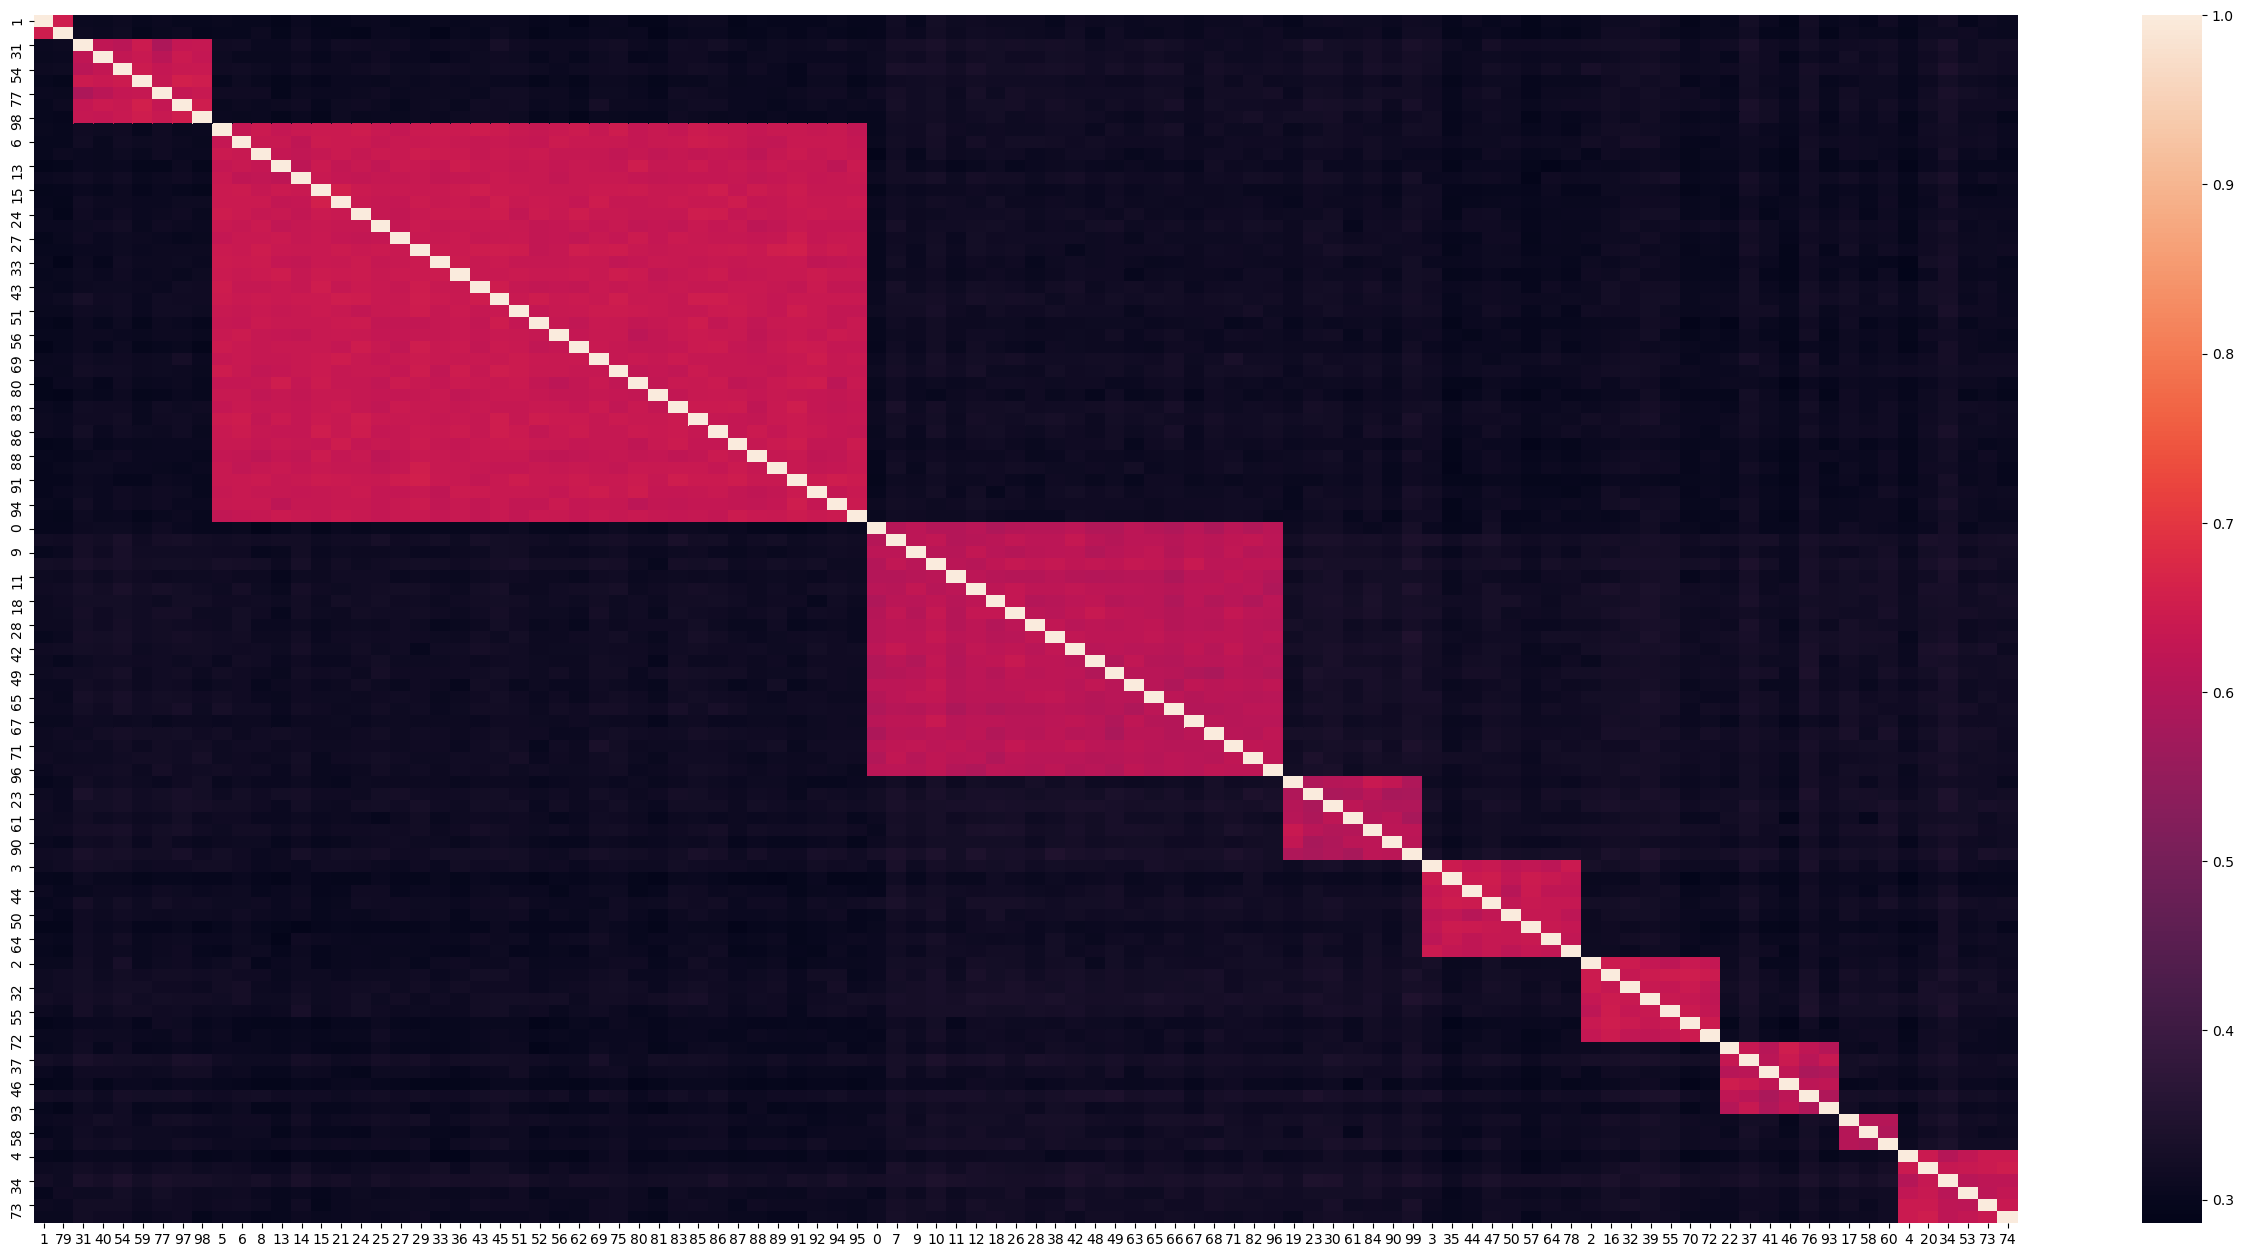

In [5]:
from finance_ml.clustering import cluster_kmeans_top, cluster_kmeans_base
import warnings
warnings.simplefilter('ignore')

corr1, clstrs1, silh1 = cluster_kmeans_top(x, 20, n_init=10)
print(f"The number of clusters: {len(clstrs1)}")
print(clstrs1)
sns.heatmap(corr1);

Successfully reverse correlation back to clustered.

# Stability of the number of clusters

Estimating the number of clusters involves stochasticity. So, we estimate its stability.

In [15]:
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm_notebook

from finance_ml.experiments import get_random_block_corr
from finance_ml.clustering import cluster_kmeans_base, cluster_kmeans_top


n_iter = 50
N = 100
KN_ratio = np.linspace(0.1, 0.5, 5)
top_data = list()
data = list()
for i in tqdm_notebook(range(n_iter)):
    for ratio in KN_ratio:
        ratio = round(ratio, 2)
        n_blocks = max(2, int(round(ratio * N)))
        max_num_blocks = max(20, n_blocks + 10)
        x = get_random_block_corr(N, n_blocks=n_blocks, is_shuffle=False, sigma=1)
        corr1, clstrs1, silh1 = cluster_kmeans_top(x, max_num_blocks, n_init=10)
        est_n_blocks = len(clstrs1)
        top_data.append({"K/N": ratio, "E[K]/K": est_n_blocks / n_blocks})
        corr1, clstrs1, silh1 = cluster_kmeans_base(x, max_num_blocks, n_init=10)
        est_n_blocks = len(clstrs1)
        data.append({"K/N": ratio, "E[K]/K": est_n_blocks / n_blocks})
data = pd.DataFrame(data)
top_data = pd.DataFrame(top_data)

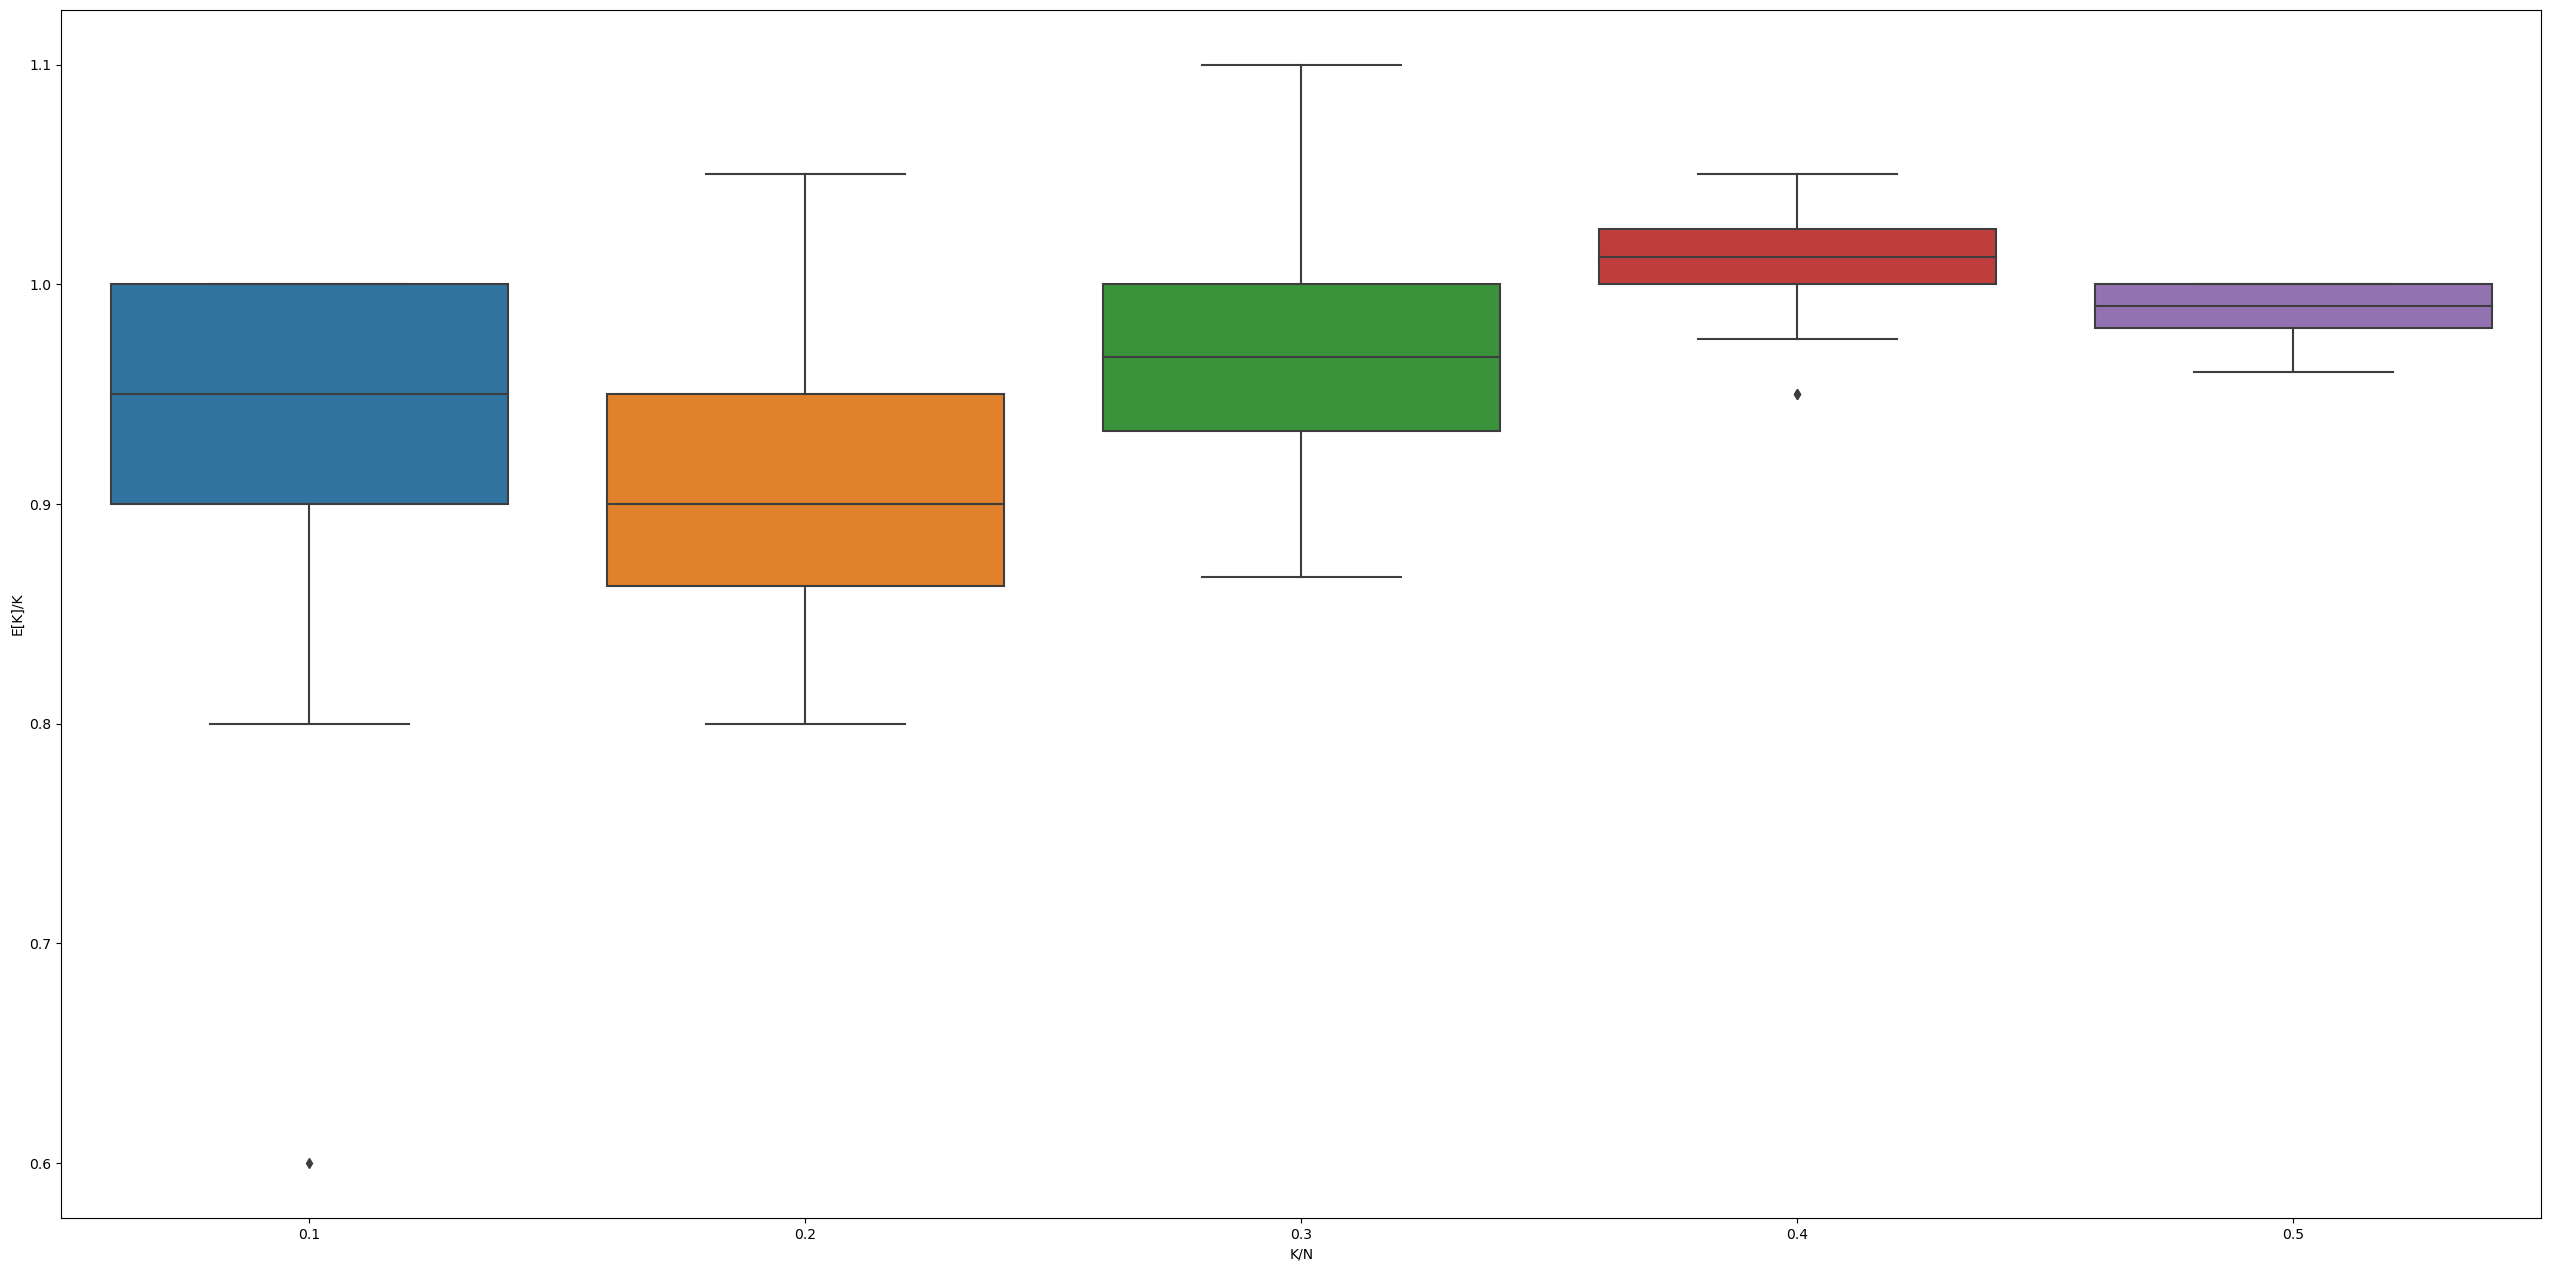

In [16]:
import seaborn as sns

tips = sns.load_dataset("tips")
sns.boxplot(x="K/N", y="E[K]/K", data=data);

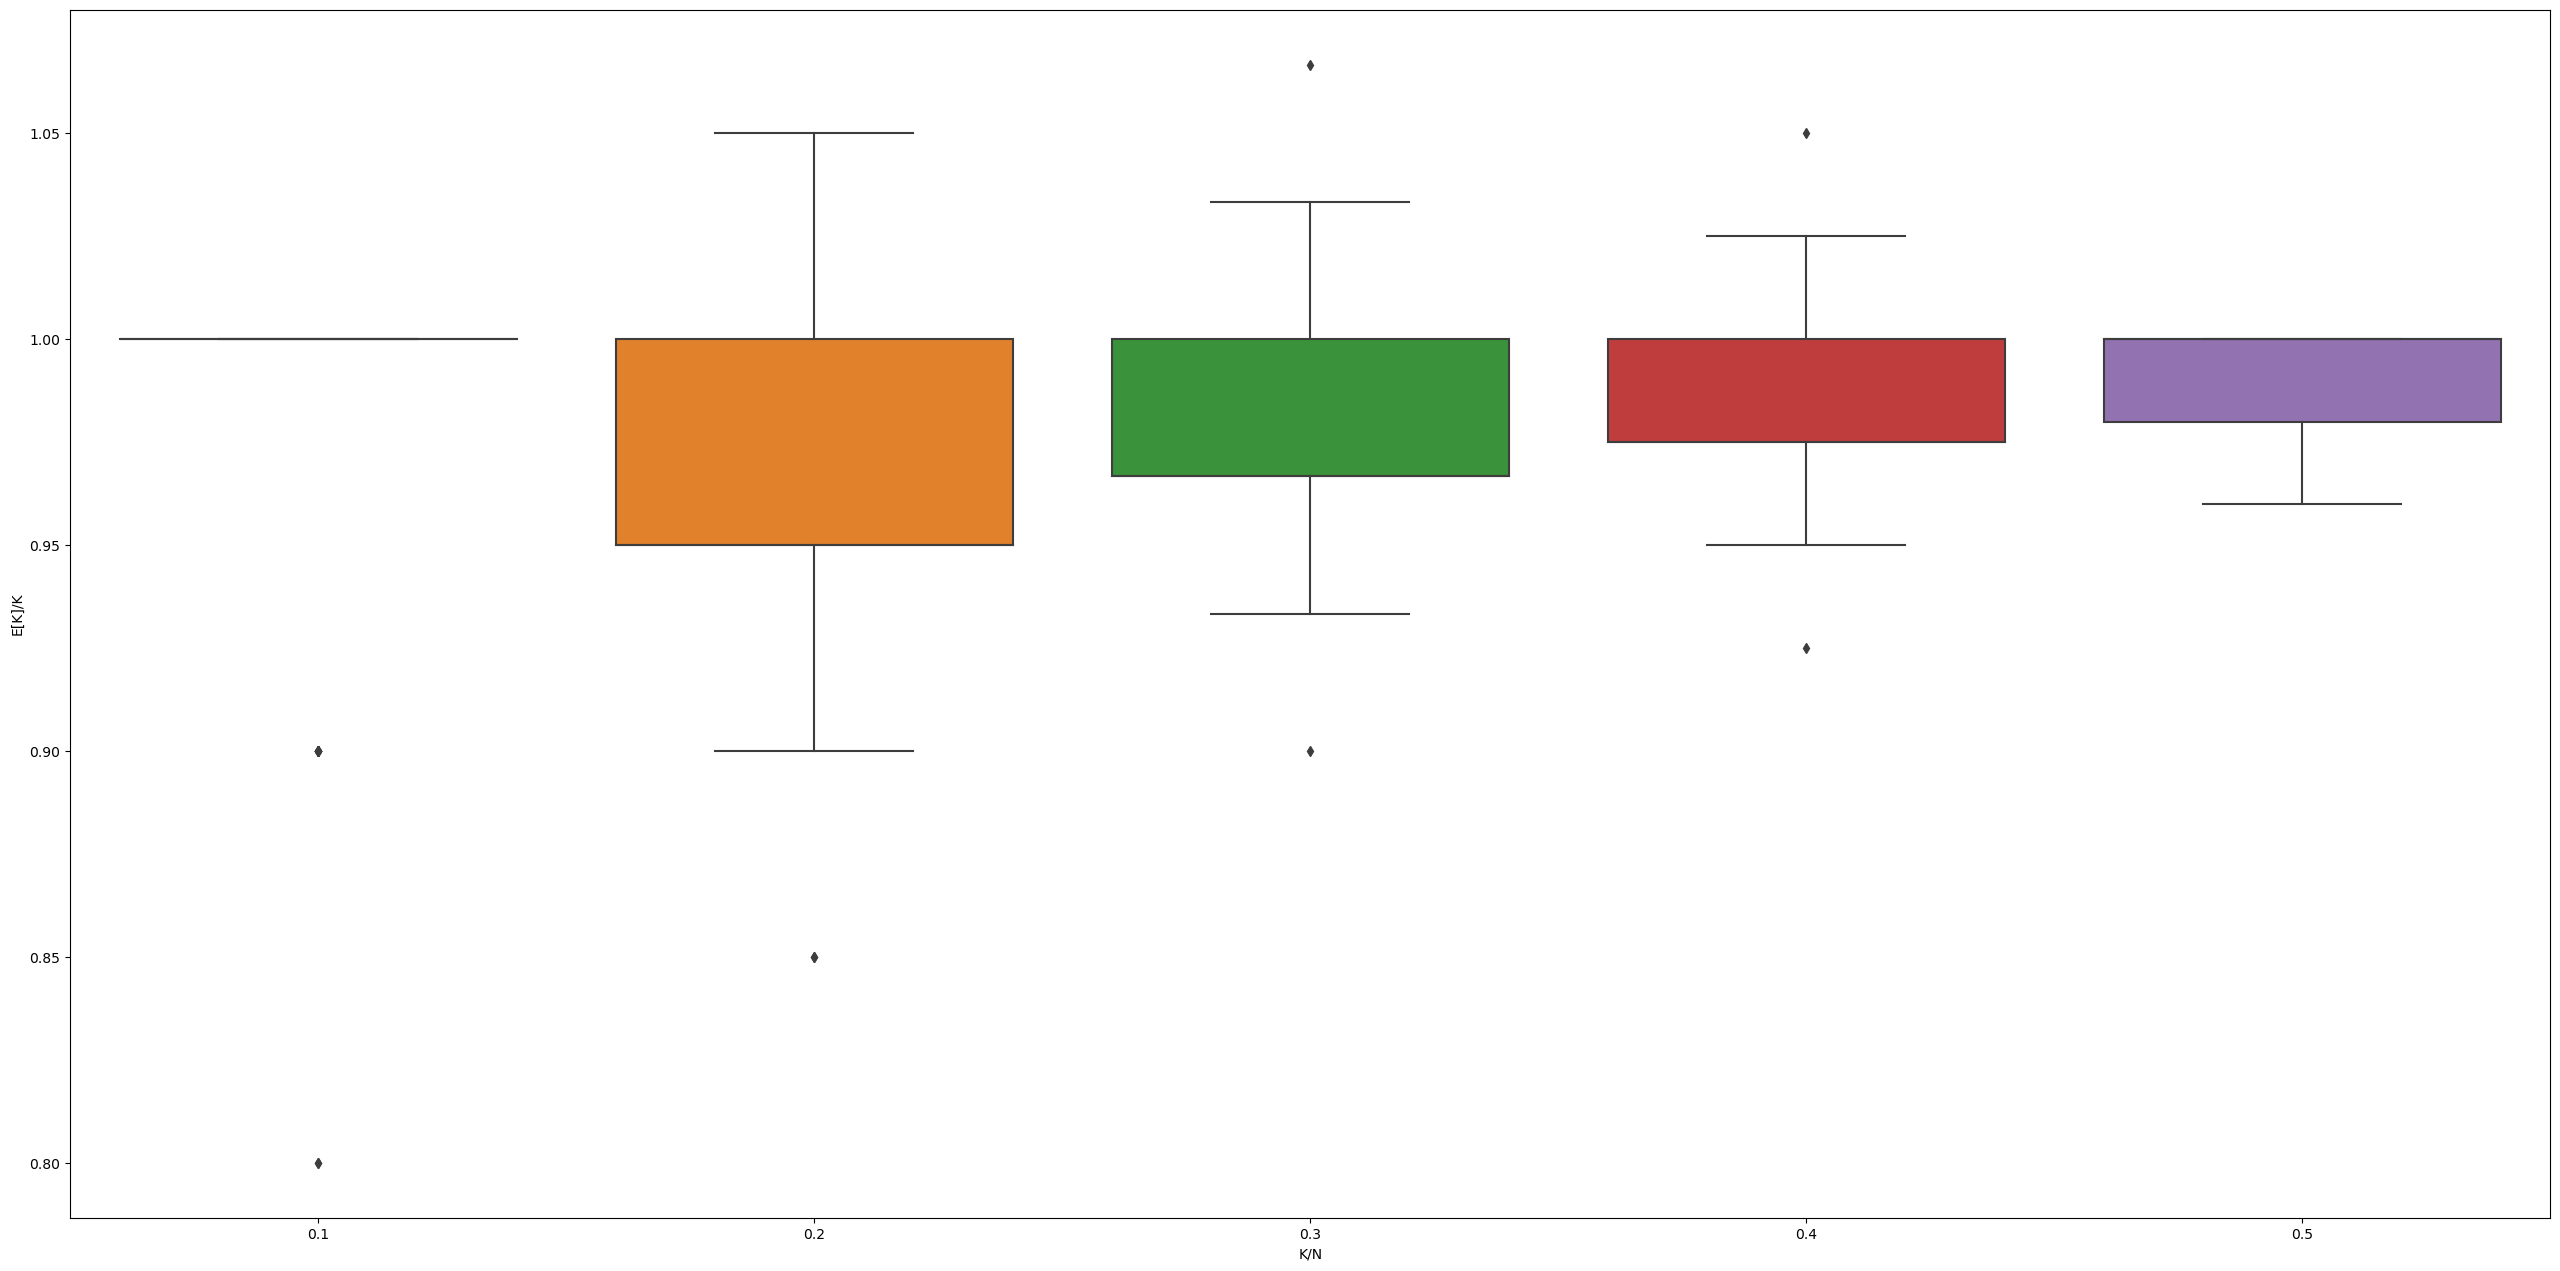

In [17]:
import seaborn as sns

tips = sns.load_dataset("tips")
sns.boxplot(x="K/N", y="E[K]/K", data=top_data);